# 1. Подготовка данных

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import SGDRegressor
from  sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import itertools

In [108]:
df_train = pd.read_csv('/datasets/gold_recovery_train.csv', index_col='date', parse_dates=['date'])
df_test = pd.read_csv('/datasets/gold_recovery_test.csv', index_col='date', parse_dates=['date'])
df_full = pd.read_csv('/datasets/gold_recovery_full.csv', index_col='date', parse_dates=['date'])

In [109]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant                      15598 non-null float64
primary_c

In [110]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.input.feed_ag                    

В тестовой выборке присутствуют данные о том что было изначально, что положили в "черный ящик для извлечения золота" и состояние флотационной установки на каждом этапе вплоть до второго этапа отчитстки.
Отсутствуют признаки связанные с выходом на каждом этапе очистки (отвальные хвосты, концентраты и т.д.), нет расчетных характеристик.

Возможно потребуется использовать последовательность моделей для предсказания выхода на каждом этапе и расчета характеристик.

---

Проверяем расчет эффективности обогащения:

In [111]:
df_train[['rougher.output.recovery', 'final.output.recovery']].describe()

,rougher.output.recovery,final.output.recovery
count,14287.000000,15339.000000
mean,82.394201,67.213166
std,15.096808,11.960446
min,0.000000,0.000000
25%,79.818372,62.625685
50%,85.235997,67.644601
75%,90.131691,72.824595
max,100.000000,100.000000


In [112]:
def recovery(df, word):
    
    if word == 'rougher':
        c = df['rougher.output.concentrate_au']
        f = df['rougher.input.feed_au']
        t = df['rougher.output.tail_au']
        
    if word == 'final':
        c = df['final.output.concentrate_au']
        f = df['rougher.input.feed_au']
        t = df['final.output.tail_au']        
    
    rec = (c * (f - t)) / (f * (c - t))
    rec = rec.agg(lambda x: np.nan if x > 1 or x < 0 else x)
    return rec * 100

In [113]:
recovery_check = recovery(df_train, 'rougher').dropna()
print('MAE_rougher: {:.15%}'.format(mean_absolute_error(df_train['rougher.output.recovery'].dropna(), 
                                                recovery_check)))
print('MAE_final: {:.15%}'.format(mean_absolute_error(df_train['final.output.recovery'].dropna(), 
                                                recovery(df_train, 'final').dropna())))

MAE_rougher: 0.000000000000944%
MAE_final: 0.000000000000816%


MAЕ ничтожно мало, что означает, с расчетами все в порядке. Чего не скажешь о данных. 

Более 2000 значений NaN являются результатом некорректных результатов полученных по этой формуле. Часть с умножением на "концентрат" должна быть меньше или равна части знаменателю с умножением на "исходное сырье", иначе значения будут больше 100%. Это дает следующие ограничения С > F > T. Доля золота после флотации больше доли золота в сырье, доля золота в отвальных хвостах меньше чем в сырье и концентрате после флотации.

Но это идельный случай. Совсем необязательно что с данными какая-то проблема, скорее всего, на такие значения оказывает влияние нестабильность процессов производства. Эти данные нельзя просто отбросить.

----

Как было отмечено выше и указанно в задании, данные, отсутствующие в тестовой выборке, output параметры недоступны, потому что замеряются и рассчитываются значительно позже, они являются результатом выполнения каждого этапа по извлечению концентрата. Также отсутсвуют расчетные характеристики.

In [114]:
df_train[['rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.input.feed_au', 
          'rougher.input.floatbank10_sulfate', 'rougher.input.feed_rate', 'rougher.input.feed_size']].sample(5)

,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.feed_rate,rougher.input.feed_size
date,,,,,
2017-01-03 17:59:59,2800.970474,8.013164,11.419977,497.730166,47.744644
2016-03-05 09:00:00,2697.917128,4.700981,6.995041,550.860736,57.874052
2016-02-13 14:00:00,2896.925015,6.359342,9.805628,500.425483,52.036769
2017-08-25 07:59:59,4444.087659,5.976095,15.999869,599.557660,57.723014
2016-07-18 08:59:59,2903.601570,9.575512,13.641050,498.290136,44.594384


In [115]:
df_train[['rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.input.feed_au', 
          'rougher.input.floatbank11_sulfate', 'rougher.input.feed_rate', 'rougher.input.feed_size']].sample(5)

,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.input.feed_au,rougher.input.floatbank11_sulfate,rougher.input.feed_rate,rougher.input.feed_size
date,,,,,
2016-06-05 22:59:59,3268.105320,7.749207,11.994498,468.876064,55.555937
2017-06-16 03:59:59,4399.626211,8.595235,15.999464,440.485707,339.234599
2018-03-26 08:59:59,2486.615080,7.577164,10.169902,541.937500,72.928287
2016-03-03 13:00:00,2990.264317,6.571386,11.021534,551.902418,58.008695
2017-02-18 13:59:59,2741.128142,12.004040,10.002633,300.586986,46.896865


In [116]:
df_train[['rougher.calculation.au_pb_ratio', 'rougher.input.feed_au', 'rougher.input.feed_pb']].sample(5)

,rougher.calculation.au_pb_ratio,rougher.input.feed_au,rougher.input.feed_pb
date,,,
2018-02-05 18:59:59,2.135265,11.217886,5.253627
2018-07-04 08:59:59,1.285182,6.062466,4.717203
2017-01-26 06:59:59,3.063223,9.910469,3.235307
2016-07-23 00:59:59,3.057754,8.908948,2.913560
2017-05-26 01:59:59,2.043169,9.407528,4.604380


Можно добавить в тестовую выборку столбец rougher.calculation.au_pb_ratio. Но в определенной ситуации это даст NaN и заполнены в трнировочном сете они не очень, поэтому обойдемся вообще без расчетных данных.

---
Необходимо заполнить пропуски в данных, как в тестовой, так и в тренировочной выборке.

In [117]:
df_train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000000,16788.000000,16490.000000,16789.000000,15339.000000,16794.000000,16677.000000,16715.000000,16794.000000,15553.000000,...,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.000000,16775.000000,16776.000000,16757.000000,16775.000000
mean,4.716907,9.113559,8.301123,39.467217,67.213166,8.757048,2.360327,9.303932,2.687512,129.479789,...,19.101874,-494.164481,14.778164,-476.600082,15.779488,-500.230146,12.377241,-498.956257,18.429208,-521.801826
std,2.096718,3.389495,3.825760,13.917227,11.960446,3.634103,1.215576,4.263208,1.272757,45.386931,...,6.883163,84.803334,5.999149,89.381172,6.834703,76.983542,6.219989,82.146207,6.958294,77.170888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.021781,-0.423260,-799.741097,0.427084,-800.258209,0.024270,-810.473526
25%,3.971262,8.825748,6.939185,42.055722,62.625685,7.610544,1.641604,7.870275,2.172953,103.064021,...,14.508299,-500.837689,10.741388,-500.269182,10.977713,-500.530594,8.925586,-500.147603,13.977626,-501.080595
50%,4.869346,10.065316,8.557228,44.498874,67.644601,9.220393,2.453690,10.021968,2.781132,131.783108,...,19.986958,-499.778379,14.943933,-499.593286,15.998340,-499.784231,11.092839,-499.933330,18.034960,-500.109898
75%,5.821176,11.054809,10.289741,45.976222,72.824595,10.971110,3.192404,11.648573,3.416936,159.539839,...,24.983961,-494.648754,20.023751,-400.137948,20.000701,-496.531781,15.979467,-498.418000,24.984992,-499.565540
max,16.001945,17.031899,18.124851,53.611374,100.000000,19.552149,6.086532,22.317730,9.789625,251.999948,...,60.000000,-127.692333,28.003828,-71.472472,63.116298,-275.073125,39.846228,-120.190931,54.876806,-39.784927


Медиана или среднее сильно повлияют на качество данных. В задании сказанно, что соседние по времени параметры часто похожи, лучше будет воспользоваться этой зависимостью и воссоздать данные более правдоподобно.

Стоит также определиться с тем какие столбцы стоит использовать для обучения, а какие нет. 

Рассчетные параметры, которые не удалось воспроизвести, для обучения модели использовать не будем. Recovery можно расчитывать получая моделями C и T (это 2 разные модели на 3 разных этапа процесса).

In [118]:
print('Дубли : ', df_train.duplicated().sum())
df_train.loc[df_train['rougher.input.feed_au'].isnull() == True].head(11)

Дубли :  16


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-02-15 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-09 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-09 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-09 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-04 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-04 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.145696,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-04 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.111099,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-04 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-04 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Считаю, что такие значения необходимо сбросить.

In [119]:
indx = df_train.loc[df_train['rougher.input.feed_au'].isnull() == True].index
df_train = df_train.drop(index=df_train.loc[indx].index)

df_train = df_train.fillna(method='ffill')

print('Дубли : ', df_train.duplicated().sum())
df_train.describe()

Дубли :  0


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16777.000000,16777.000000,16777.000000,16777.000000,16777.000000,16777.000000,16777.000000,16777.000000,16777.000000,16777.000000,...,16777.000000,16777.000000,16777.000000,16777.000000,16777.000000,16777.000000,16777.000000,16777.000000,16777.000000,16777.000000
mean,4.717560,9.112273,8.197469,39.467048,66.351665,8.763647,2.348346,9.274106,2.689467,121.040795,...,19.049319,-494.737678,14.770061,-476.803595,15.777068,-500.269419,12.375559,-498.974152,18.408122,-521.856588
std,2.097026,3.389132,3.883648,13.918459,13.300494,3.628316,1.220938,4.283651,1.271356,53.464714,...,6.945208,85.726264,6.007335,89.692429,6.836734,77.057521,6.220997,82.176635,6.981190,77.257963
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.021781,-0.423260,-799.741097,0.427084,-800.258209,0.024270,-810.473526
25%,3.971365,8.825288,6.851352,42.054605,61.766488,7.612594,1.622954,7.838671,2.173866,94.719604,...,14.503399,-500.845323,10.527400,-500.271427,10.977407,-500.531130,8.924228,-500.147626,13.972266,-501.082849
50%,4.870399,10.063896,8.503123,44.499769,67.437350,9.224331,2.443871,10.005087,2.782136,127.755014,...,19.986036,-499.781325,14.943179,-499.595934,15.998078,-499.784729,11.084167,-499.933364,18.033270,-500.110388
75%,5.822102,11.053135,10.250344,45.976838,72.847691,10.972043,3.188171,11.641842,3.417151,156.898044,...,24.983681,-494.829418,20.023582,-400.138701,20.000632,-496.547710,15.979226,-498.421955,24.984889,-499.565597
max,16.001945,17.031899,18.124851,53.611374,100.000000,19.552149,6.086532,22.317730,9.789625,251.999948,...,60.000000,-127.692333,28.003828,-71.472472,63.116298,-275.073125,39.846228,-120.190931,54.876806,-39.784927


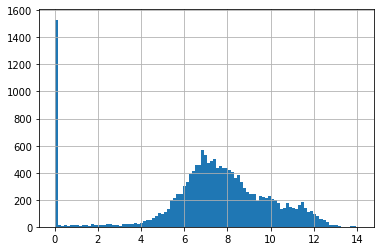

In [120]:
df_train['rougher.input.feed_au'].hist(bins=100)

Меня чертовски смущают эти нули, но сбрасывать нельзя, они могут быть в тестовой выборке. Дубли сбросим, все равно их очень мало.

---
Для тестовой:

In [121]:
df_test.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,...,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,...,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
std,49.608602,3.353105,0.611526,0.693246,310.453166,61.339256,313.224286,67.139074,309.980748,62.671873,...,4.660835,62.756748,4.304086,105.549424,3.762827,58.864651,3.312471,68.785898,5.404514,69.919839
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,...,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,143.340022,6.411500,6.885625,0.888769,1497.190681,-500.455211,1497.150234,-500.936639,1437.050321,-501.300441,...,12.057838,-501.054741,11.880119,-500.419113,10.123459,-500.879383,7.991208,-500.223089,13.012422,-500.833821
50%,176.103893,8.023252,7.259333,1.183362,1554.659783,-499.997402,1553.268084,-500.066588,1546.160672,-500.079537,...,17.001867,-500.160145,14.952102,-499.644328,12.062877,-500.047621,9.980774,-500.001338,16.007242,-500.041085
75%,207.240761,10.017725,7.650000,1.763797,1601.681656,-499.575313,1601.784707,-499.323361,1600.785573,-499.009545,...,18.030985,-499.441529,15.940011,-401.523664,15.017881,-499.297033,11.992176,-499.722835,21.009076,-499.395621
max,274.409626,40.024582,15.500000,5.433169,2212.432090,-57.195404,1975.147923,-142.527229,1715.053773,-150.937035,...,30.051797,-401.565212,31.269706,-6.506986,25.258848,-244.483566,14.090194,-126.463446,26.705889,-29.093593


In [122]:
print('Дубли до : ', df_test.duplicated().sum())

df_test = df_test.fillna(method='ffill')

print('Дубли после : ', df_test.duplicated().sum())
df_test = df_test.drop_duplicates()

df_test.describe()

Дубли до :  6
Дубли после :  8


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,...,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000
mean,162.602966,8.207901,7.264524,1.290396,1482.240491,-509.045966,1487.199761,-511.729944,1468.812851,-509.726240,...,15.637965,-516.237309,13.148184,-476.357508,12.309812,-512.189706,9.474578,-505.011398,16.684622,-512.332843
std,59.849513,3.585626,0.611791,0.713851,310.314416,61.298112,313.108742,67.094201,309.887492,62.630303,...,4.657939,62.718635,4.301663,105.478426,3.760322,58.826473,3.311627,68.739044,5.403168,69.873857
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,...,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,136.587127,6.037186,6.880000,0.850854,1497.219854,-500.454275,1497.171993,-500.947589,1437.697158,-501.297283,...,12.059159,-501.051736,11.885401,-500.418695,10.128679,-500.876879,7.991405,-500.224666,13.012903,-500.832879
50%,173.024627,8.001446,7.251667,1.148933,1554.869321,-499.998545,1553.458834,-500.067445,1546.519365,-500.077322,...,17.001990,-500.159088,14.952477,-499.641343,12.069791,-500.046502,9.982178,-500.001741,16.007454,-500.039809
75%,205.186098,10.004723,7.650000,1.708032,1601.710250,-499.575939,1601.819533,-499.324170,1600.804804,-499.005178,...,18.030594,-499.433397,15.939669,-401.550196,15.017544,-499.293640,11.992551,-499.722899,21.009064,-499.389057
max,274.409626,40.024582,15.500000,5.433169,2212.432090,-57.195404,1975.147923,-142.527229,1715.053773,-150.937035,...,30.051797,-401.565212,31.269706,-6.506986,25.258848,-244.483566,14.090194,-126.463446,26.705889,-29.093593


# 2. Анализ данных

Как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6bafefba8>,
      dtype=object)

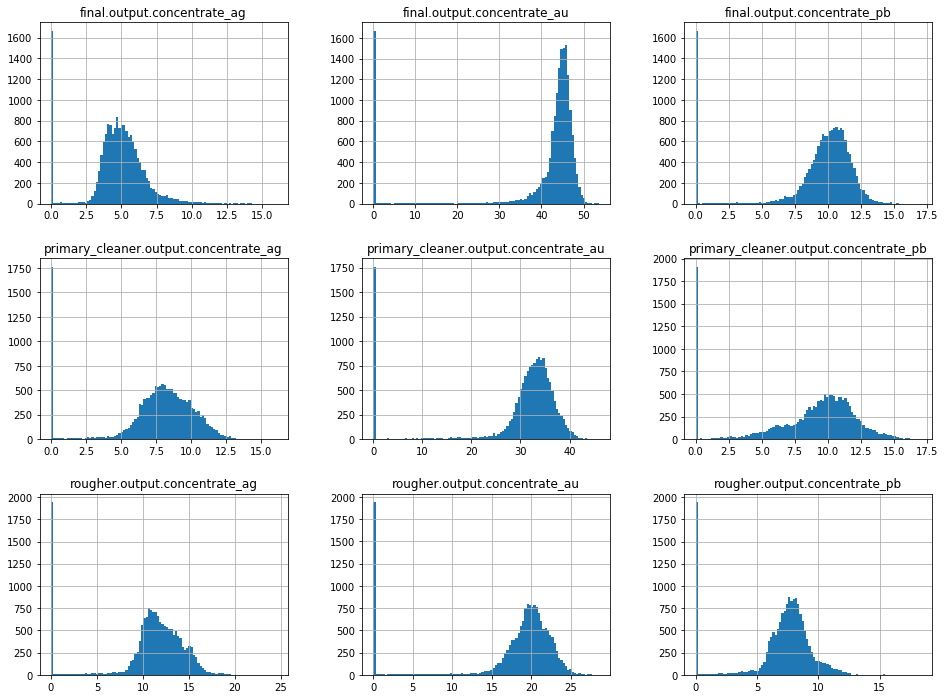

In [123]:
col_s =[]

for con in ['.output.concentrate_au', '.output.concentrate_ag', 
            '.output.concentrate_pb']:
    
    for col in df_train.columns:
        if con in col:
            col_s.append(col)
            
df_train.hist(col_s, bins=100, figsize=(16, 12))

Огромное кол-во нулей в данных можно объяснить данными и методом заполнения пропусков. То что к финалу кол-во нулей уменьшается объясняется процессом очистки, повышающем концентрацию металлов.



---

Распределения размеров гранул сырья на обучающей и тестовой выборках:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6b885ba90>],
      dtype=object)

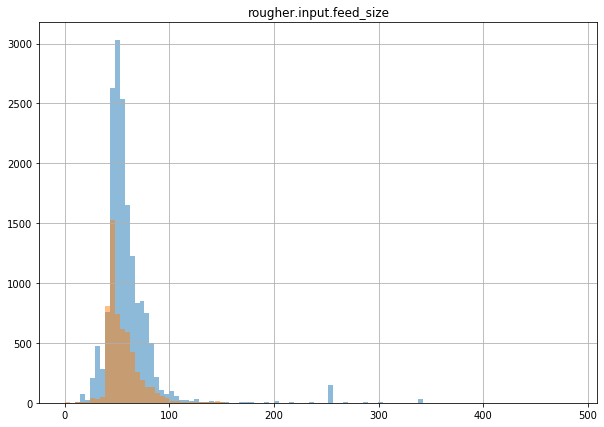

In [124]:
ax = df_train.hist('rougher.input.feed_size', bins=100, alpha=0.5, figsize=(10, 7))
df_test.hist('rougher.input.feed_size', bins=100, alpha=0.5, ax=ax, figsize=(10, 7))

Можно даже сказать совпадает, процентов на 90.

---

Суммарное распределение концентраций всех веществ на разных стадиях: в сырье (input), в черновом (rough) и финальном концентратах.

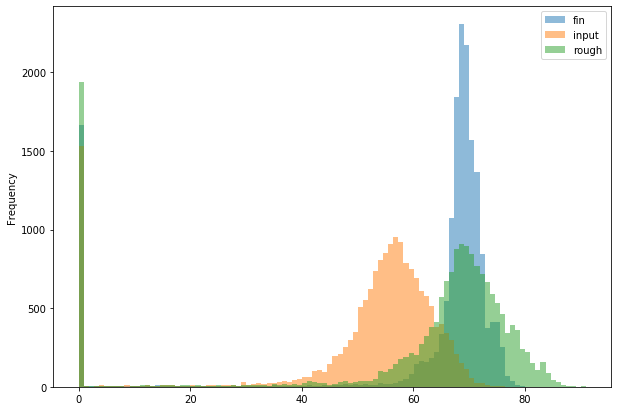

In [125]:
col_f = []
col_i = []
col_r = []
all_con = pd.DataFrame()

for col in df_train.columns:
    if 'final.output.concentrate_' in col:
        col_f.append(col)
        all_con['fin'] = df_train[col_f].agg('sum', axis=1)
    if 'input.feed_' in col:
        if 'rate' not in col:
            if 'size' not in col:
                col_i.append(col)
                all_con['input'] = df_train[col_i].agg('sum', axis=1)
    if 'rougher.output.concentrate_' in col:
        col_r.append(col)
        all_con['rough'] = df_train[col_r].agg('sum', axis=1)

all_con.plot.hist(bins=100, alpha=0.5, figsize=(10, 7))

К сожалению, не могу найти никаких аномалий. Суммарная концентрация всех металлов ожидаемо повышается, по мере прохождения по этапам очистки. Вот только нули. Но их присутствие уже объяснялось выше и нет ничего аномального в том, если загрузить в "черный ящик для золота" сырье без содержания золота, получить на выходе ноль концентрата на всех этапах.

Ниже удалю и проверю еще раз моделью

# 3. Модель

In [126]:
def sMAPE(y_pred, y_true):
    
    num = (abs(y_true - y_pred)) / ((abs(y_true) + abs(y_pred)) / 2)
    num = ((1 / len(num)) * num.sum()) * 100
    
    return num

#создать свой счетчик метрики для такого подхода к решению не получится.
#покрайней мере на данный момент я не знаю как.
#нужно принимать предсказания 2х переменных и на основе их вычислять метрику.
#внутри кросс валидации такого не сделать, т.к. она считает метрику для того что предсказала.
#получается в таком случае считать sMAPE можно только по факту.

smape_score = make_scorer(sMAPE, greater_is_better=False)

In [127]:
print('Проверка sMAPE: {:.15%}'.format(sMAPE(df_train['rougher.output.recovery'].dropna(), 
                                             recovery_check)))

Проверка sMAPE: 0.000000000000988%


In [265]:
def stage_sep(df):
    
    r_stage = []
    p_stage = []
    
    for col in df.columns:
        
        if 'rougher.' in col:
            r_stage.append(col)
        if 'primary_cleaner.' in col:
            p_stage.append(col)
    
    rougher = df[r_stage]
    primary = df[r_stage].join(df[p_stage])
    fin = df
    
    return rougher, primary, fin

In [266]:
rougher_train, primary_train, fin_train = stage_sep(df_train[df_test.columns])
primary_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16777 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 34 columns):
rougher.input.feed_ag                       16777 non-null float64
rougher.input.feed_pb                       16777 non-null float64
rougher.input.feed_rate                     16777 non-null float64
rougher.input.feed_size                     16777 non-null float64
rougher.input.feed_sol                      16777 non-null float64
rougher.input.feed_au                       16777 non-null float64
rougher.input.floatbank10_sulfate           16777 non-null float64
rougher.input.floatbank10_xanthate          16777 non-null float64
rougher.input.floatbank11_sulfate           16777 non-null float64
rougher.input.floatbank11_xanthate          16777 non-null float64
rougher.state.floatbank10_a_air             16777 non-null float64
rougher.state.floatbank10_a_level           16777 non-null float64
rougher.state.floatbank10_b_air             16777 no

Целевые признаки для 1 этапа.

In [267]:
y_rougher_train = df_train[['rougher.output.concentrate_au', 'rougher.output.tail_au']]
print(df_train[['rougher.output.concentrate_au', 'rougher.output.tail_au']].describe())
rougher_train.describe()

       rougher.output.concentrate_au  rougher.output.tail_au
count                   16777.000000            16777.000000
mean                       17.402578                1.810358
std                         6.920777                0.776157
min                         0.000000                0.020676
25%                        17.444359                1.322397
50%                        19.644668                1.768349
75%                        21.224505                2.224910
max                        28.522811                9.688980


,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,...,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
count,16777.000000,16777.000000,16777.000000,16777.000000,16777.000000,16777.000000,16777.000000,16777.000000,16777.000000,16777.000000,...,16777.000000,16777.000000,16777.000000,16777.000000,16777.000000,16777.000000,16777.000000,16777.000000,16777.000000,16777.000000
mean,7.832419,3.199849,427.155736,60.286540,32.442405,7.170717,10.638222,5.278490,10.284438,5.306180,...,1254.539540,-475.142318,1231.783896,-474.378736,1148.708228,-475.863305,1029.952487,-475.227147,985.033347,-475.433403
std,3.139094,1.485907,165.166442,30.558166,11.842719,3.002113,4.537766,1.995268,4.798358,1.926824,...,327.132519,69.732307,341.214535,66.737063,324.108613,63.789415,288.107643,68.475973,272.581751,70.257115
min,0.000000,0.000000,0.000044,9.659576,0.000000,0.000000,0.000002,0.000003,0.000049,0.000010,...,-0.759568,-650.437575,-0.378521,-650.151190,-1.197435,-649.300693,-2.163619,-650.196204,-2.636171,-650.072357
25%,6.889607,2.526260,379.862474,47.563020,32.033787,6.203083,8.965457,4.798264,8.477491,4.696929,...,1196.616744,-500.282622,1100.102376,-500.324919,1045.156298,-500.584594,903.966498,-500.391208,900.045425,-500.728344
50%,7.938248,3.282169,483.852764,54.115931,36.305636,7.443530,11.001836,5.702095,10.998916,5.703530,...,1299.687773,-499.835871,1298.448964,-499.774281,1199.258672,-499.634947,1049.245988,-499.722253,999.832527,-499.566725
75%,9.829866,4.172018,539.436449,65.461553,39.013615,8.965193,13.003314,6.500580,13.001227,6.502816,...,1436.486559,-400.858626,1448.654022,-401.249031,1308.026102,-402.308383,1199.515080,-401.295027,1099.745359,-401.986146
max,14.869652,7.142594,717.508837,484.967466,48.363177,14.093363,36.118275,16.260770,37.980648,9.698407,...,1809.194008,9.457822,2499.129174,-10.242658,2077.222699,21.365035,2330.310425,-2.406020,1950.493751,-21.745268


In [268]:
scaler = StandardScaler()
scaler.fit(rougher_train)
rougher_train = scaler.transform(rougher_train)

In [28]:
for n in [100, 150, 200]:
    for m in [None, 3, 6, 9]:
        print('max_depth %s estimators %s' % (m, n))
        for y in y_rougher_train.columns:
            model = RandomForestRegressor(n_estimators=n, max_depth=m, random_state=42)
            score = pd.Series(cross_val_score(model, rougher_train, y_rougher_train[y], cv=5)).mean()
            print(y, '\n', score)

max_depth None estimators 100
rougher.output.concentrate_au 
 0.5995063802772942
max_depth None estimators 100
rougher.output.tail_au 
 -0.38820625274226694
max_depth 3 estimators 100
rougher.output.concentrate_au 
 0.5819481586638714
max_depth 3 estimators 100
rougher.output.tail_au 
 -0.183819063410743
max_depth 6 estimators 100
rougher.output.concentrate_au 
 0.603727293291205
max_depth 6 estimators 100
rougher.output.tail_au 
 -0.32845591700158794
max_depth 9 estimators 100
rougher.output.concentrate_au 
 0.6047084812461531
max_depth 9 estimators 100
rougher.output.tail_au 
 -0.3696305342395053
max_depth None estimators 150
rougher.output.concentrate_au 
 0.6037321893452622
max_depth None estimators 150
rougher.output.tail_au 
 -0.3928518829904093
max_depth 3 estimators 150
rougher.output.concentrate_au 
 0.582786259922094
max_depth 3 estimators 150
rougher.output.tail_au 
 -0.18611386967466384
max_depth 6 estimators 150
rougher.output.concentrate_au 
 0.6041263245967208
max_depth 

n 200 m 9

Что означают эти отрицательные значения не понятно. Я лишь понял, что они могут быть и с ними можно работать, но как понть какое из отрицательных лучше, то что ближе к 0 или то что дальше?

In [57]:
# надо попробовать гридсерч

param_sgdr = {'penalty': [None, 'l2', 'l1', 'elasticnet'], 'average': [True, False],
              'alpha': [0.0001, 0.001, 0.01, 0.1], 'max_iter': [1000, 2000, 500]}

grid_search = GridSearchCV(SGDRegressor(random_state=42), param_sgdr, 
                           n_jobs=-1, cv=5)

grid_search.fit(rougher_train, y_rougher_train['rougher.output.concentrate_au'])
best_param_sgdr = grid_search.best_params_
print(best_param_sgdr)
print(grid_search.best_score_)

{'alpha': 0.1, 'average': True, 'max_iter': 1000, 'penalty': 'l2'}
0.5382562321122925


In [60]:
param_rfr = {'n_estimators': [50, 100, 150, 200], 'max_depth': [3, 6, 9, 12]}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_rfr,
                           n_jobs=-1, cv=5)

grid_search.fit(rougher_train, y_rougher_train['rougher.output.concentrate_au'])
best_param_rfr = grid_search.best_params_
print(best_param_rfr)
print(grid_search.best_score_)

{'max_depth': 12, 'n_estimators': 200}
0.6088425438216281


Гридсерч показал другие значения лучших параметров. Но они считаются по метрике для одного признака, а sMAPE считается на основе двух целевых признаков. Тут надо определиться с метрикой для одной целевой переменной и согласно ей подбирать параметры.

Конечно есть вариант засунуть grid в model_cycle и смотреть все по факту, но и это будет не совсем верно, все равно параметры моделей будут выбираться согласно иной метрики. Придется сделать свой аналог кросс-валидации для 2 таргетов с расчетом sMAPE. Не так уж сложно звучит.

In [240]:
#как вариант можно начать с этого:

def train_model_smape_metric(modell, df_train, cv, params):
    
    scaler = StandardScaler()
    
    rougher_train, primary_train, fin_train = stage_sep(df_train)
    y_rougher_train = df_train[['rougher.output.concentrate_au', 'rougher.output.tail_au']]
    y_fin_train = df_train[['final.output.concentrate_au', 'final.output.tail_au']]
    
    # зададим размер блока
    sample_size = int(len(df_train)/cv)
    
    # выделяем параметры
    k = list(params.keys())
    vals = itertools.product(*params.values())
    paramas = []
    for v in vals:
        paramas.append(dict(zip(k, v)))
    total_ = []
    indx = []
    
    for parms in paramas:
        
        p = str(parms)
        indx.append(p)
        
        if modell == 'rfr':
            model = RandomForestRegressor(**parms, random_state=42)
        if modell == 'sgdr':
            model = SGDRegressor(**parms, random_state=42)
            
        predict = pd.DataFrame()
        temp = pd.DataFrame()
            
        for X_train, y_train, word in [(rougher_train, y_rougher_train, 'rougher'), 
                                       (fin_train, y_fin_train, 'final')]:
                
            if word == 'rougher':
                y_true = df_train['rougher.output.recovery']
            else:
                y_true = df_train['final.output.recovery']
            smape = []
                
            # тут начинается кросс-валидация
            for i in range(0, len(X_train), sample_size):
                valid_indexes = X_train[i:i+sample_size].index
                train_indexes = X_train[~X_train.index.isin(valid_indexes)].index
                features_train = X_train.loc[train_indexes]
                target_train = y_train.loc[train_indexes]
                features_valid_ = X_train.loc[valid_indexes]
                
                scaler.fit(features_train)
                features_train = scaler.transform(features_train)
                features_valid = scaler.transform(features_valid_)
                
                for y in y_train.columns:
                    model.fit(features_train, target_train[y])
                    features_valid_[y] = model.predict(features_valid)
                
                smape.append(sMAPE(recovery(features_valid_, word), y_true))
            
            temp[word] = smape
            
        total_.append(0.25 * temp['rougher'].mean() + 0.75 * temp['final'].mean())
        
    total = pd.DataFrame(index=indx, data=total_)
    best_param = eval(total.idxmin()[0])
    
    return total, best_param

# Боги, я создал монстра...

In [241]:
param_sgdr = {'penalty': ['l2', 'l1', 'elasticnet'], 'average': [True, False],
              'alpha': [0.0001, 0.001, 0.01, 0.1], 'max_iter': [1000, 2000, 500]}
param_rfr = {'n_estimators': [50, 100, 150, 200], 'max_depth': [3, 6, 9, 12]}


total, best_param_sgdr = train_model_smape_metric('sgdr', df_train, 3, param_sgdr)

,0
"{'penalty': 'l2', 'average': True, 'alpha': 0.0001, 'max_iter': 1000}",0.925830
"{'penalty': 'l2', 'average': True, 'alpha': 0.0001, 'max_iter': 2000}",0.925830
"{'penalty': 'l2', 'average': True, 'alpha': 0.0001, 'max_iter': 500}",0.925830
"{'penalty': 'l2', 'average': True, 'alpha': 0.001, 'max_iter': 1000}",0.898632
"{'penalty': 'l2', 'average': True, 'alpha': 0.001, 'max_iter': 2000}",0.898632
...,...
"{'penalty': 'elasticnet', 'average': False, 'alpha': 0.01, 'max_iter': 2000}",1.390894
"{'penalty': 'elasticnet', 'average': False, 'alpha': 0.01, 'max_iter': 500}",1.390894
"{'penalty': 'elasticnet', 'average': False, 'alpha': 0.1, 'max_iter': 1000}",1.272626
"{'penalty': 'elasticnet', 'average': False, 'alpha': 0.1, 'max_iter': 2000}",1.272626


In [262]:
print(total.min())
print(eval(total.idxmin()[0]))
total.head(15)

0    0.386861
dtype: float64
{'penalty': 'l1', 'average': False, 'alpha': 0.1, 'max_iter': 1000}


,0
"{'penalty': 'l2', 'average': True, 'alpha': 0.0001, 'max_iter': 1000}",0.925830
"{'penalty': 'l2', 'average': True, 'alpha': 0.0001, 'max_iter': 2000}",0.925830
"{'penalty': 'l2', 'average': True, 'alpha': 0.0001, 'max_iter': 500}",0.925830
"{'penalty': 'l2', 'average': True, 'alpha': 0.001, 'max_iter': 1000}",0.898632
"{'penalty': 'l2', 'average': True, 'alpha': 0.001, 'max_iter': 2000}",0.898632
"{'penalty': 'l2', 'average': True, 'alpha': 0.001, 'max_iter': 500}",0.898632
"{'penalty': 'l2', 'average': True, 'alpha': 0.01, 'max_iter': 1000}",0.722941
"{'penalty': 'l2', 'average': True, 'alpha': 0.01, 'max_iter': 2000}",0.722941
"{'penalty': 'l2', 'average': True, 'alpha': 0.01, 'max_iter': 500}",0.722941
"{'penalty': 'l2', 'average': True, 'alpha': 0.1, 'max_iter': 1000}",3.025903


На случайном лесе лучше не запускать. Довольно сложно получилось проверять по своей метрике, предсказывая отдельные признаки и получая значение из них. max_iter в данном случае не имело никакого значения. Зато нашли лучшие параметры и они отличаются от тех которые находились более прямолинейным образом.

In [269]:
for p in ['l2', 'l1', 'elasticnet']:
    for b in [0.0001, 0.001, 0.01, 0.1]:
        print('penalty:', p, 'alpha:', b,)
        for y in y_rougher_train.columns:
            model = SGDRegressor(penalty=p, alpha=b, random_state=42)
            score = pd.Series(cross_val_score(model, rougher_train, y_rougher_train[y], cv=5)).mean()
            print(y, '\n', score)

penalty: None alpha: 0.0001
rougher.output.concentrate_au 
 0.5266514231414201
rougher.output.tail_au 
 -0.1281036605841366
penalty: None alpha: 0.001
rougher.output.concentrate_au 
 0.5266514231414201
rougher.output.tail_au 
 -0.1281036605841366
penalty: None alpha: 0.01
rougher.output.concentrate_au 
 0.5266514231414201
rougher.output.tail_au 
 -0.1281036605841366
penalty: None alpha: 0.1
rougher.output.concentrate_au 
 0.5266514231414201
rougher.output.tail_au 
 -0.1281036605841366
penalty: l2 alpha: 0.0001
rougher.output.concentrate_au 
 0.5267807417084679
rougher.output.tail_au 
 -0.127888034666497
penalty: l2 alpha: 0.001
rougher.output.concentrate_au 
 0.5266962963692271
rougher.output.tail_au 
 -0.12606733362098094
penalty: l2 alpha: 0.01
rougher.output.concentrate_au 
 0.5324648576341497
rougher.output.tail_au 
 -0.11644291255139519
penalty: l2 alpha: 0.1
rougher.output.concentrate_au 
 0.5339168977620282
rougher.output.tail_au 
 -0.19835272429752712
penalty: l1 alpha: 0.0001


l1 True

In [59]:
y_true = df_full.loc[df_test.index][['rougher.output.recovery', 'final.output.recovery']]
y_true = y_true.fillna(method='ffill')
y_true.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5848 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 2 columns):
rougher.output.recovery    5848 non-null float64
final.output.recovery      5848 non-null float64
dtypes: float64(2)
memory usage: 137.1 KB


In [61]:
models = [LinearRegression(), 
          RandomForestRegressor(**best_param_rfr, random_state=42), 
          SGDRegressor(**best_param_sgdr, random_state=42)]

In [47]:
def model_cycle(models, df_train, df_test, y_true):
    
    y_rougher_train = df_train[['rougher.output.concentrate_au', 'rougher.output.tail_au']]
    y_primary_train = df_train[['primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_au']]
    y_fin_train = df_train[['final.output.concentrate_au', 'final.output.tail_au']]  
    
    scaler = StandardScaler()
    
    df_trn = df_train[df_test.columns]
    rougher_train, primary_train, fin_train = stage_sep(df_trn)
    rougher_test, primary_test, fin_test = stage_sep(df_test)
    r_smape = []
    f_smape = []
    total_smape = []
    
    for model in models:
        
        print('--------Взял модель---------')
        df_temp = pd.DataFrame()
        temp = pd.DataFrame(index=df_test.index)
        
        for X_train, y_train, X_test in [(rougher_train, y_rougher_train, rougher_test), 
                                         (primary_train, y_primary_train, primary_test), 
                                         (fin_train, y_fin_train, fin_test)]:
            print('Взял данные для тренировки и теста')
            
            if len(temp.columns) != 0:
                X_test = X_test.join(temp)
                X_train = X_train.join(df_train[temp.columns])
            
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
                
            for y in y_train.columns:
                print('Тренирую')
                model.fit(X_train, y_train[y])
                print('Предсказываю')
                temp[y] = model.predict(X_test)
        
        print('Считаю sMAPE')
        df_temp = df_test.join(temp)
        
        rough_smape = sMAPE(recovery(df_temp, 'rougher'), y_true[y_true.columns[0]])
        r_smape.append(rough_smape)
        final_smape = sMAPE(recovery(df_temp, 'final'), y_true[y_true.columns[1]])
        f_smape.append(final_smape)
        total_smape.append(0.25 * rough_smape + 0.75 * final_smape)
        
    score = pd.DataFrame({'Model': ['lr', 'rfr', 'sgdr'], 'sMAPE_for_rougher': r_smape, 
                          'sMAPE_for_final': f_smape, 'Final sMAPE': total_smape})
    return score

In [49]:
model_cycle(models, df_train, df_test, y_true)

--------Взял модель---------
Взял данные для тренировки и теста
Тренирую
Предсказываю
Тренирую
Предсказываю
Взял данные для тренировки и теста
Тренирую
Предсказываю
Тренирую
Предсказываю
Взял данные для тренировки и теста
Тренирую
Предсказываю
Тренирую
Предсказываю
Считаю sMAPE
--------Взял модель---------
Взял данные для тренировки и теста
Тренирую
Предсказываю
Тренирую
Предсказываю
Взял данные для тренировки и теста
Тренирую
Предсказываю
Тренирую
Предсказываю
Взял данные для тренировки и теста
Тренирую
Предсказываю
Тренирую
Предсказываю
Считаю sMAPE
--------Взял модель---------
Взял данные для тренировки и теста
Тренирую
Предсказываю
Тренирую
Предсказываю
Взял данные для тренировки и теста
Тренирую
Предсказываю
Тренирую
Предсказываю
Взял данные для тренировки и теста
Тренирую
Предсказываю
Тренирую
Предсказываю
Считаю sMAPE


,Model,sMAPE_for_rougher,sMAPE_for_final,Final sMAPE
0,lr,7.687657,10.289091,9.638732
1,rfr,7.649647,9.828441,9.283743
2,sgdr,7.665656,10.164118,9.539502


После удаления нулей:

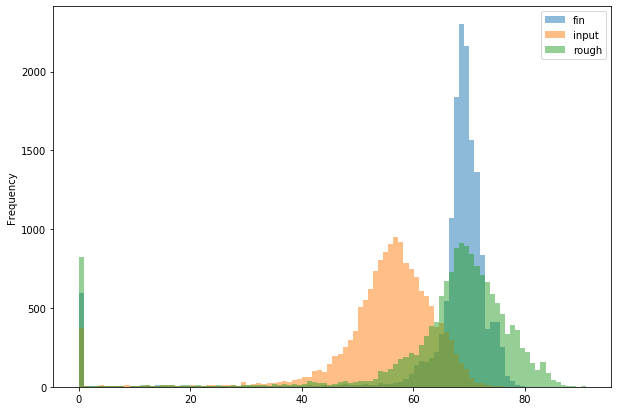

In [60]:
df_train = df_train.drop(df_train[df_train['rougher.input.feed_au'] == 0].index)

col_f = []
col_i = []
col_r = []
all_con = pd.DataFrame()

for col in df_train.columns:
    if 'final.output.concentrate_' in col:
        col_f.append(col)
        all_con['fin'] = df_train[col_f].agg('sum', axis=1)
    if 'input.feed_' in col:
        if 'rate' not in col:
            if 'size' not in col:
                col_i.append(col)
                all_con['input'] = df_train[col_i].agg('sum', axis=1)
    if 'rougher.output.concentrate_' in col:
        col_r.append(col)
        all_con['rough'] = df_train[col_r].agg('sum', axis=1)

all_con.plot.hist(bins=100, alpha=0.5, figsize=(10, 7))

In [61]:
model_cycle(models, df_train, df_test, y_true)

--------Взял модель---------
Взял данные для тренировки и теста
Тренирую
Предсказываю
Тренирую
Предсказываю
Взял данные для тренировки и теста
Тренирую
Предсказываю
Тренирую
Предсказываю
Взял данные для тренировки и теста
Тренирую
Предсказываю
Тренирую
Предсказываю
Считаю sMAPE
--------Взял модель---------
Взял данные для тренировки и теста
Тренирую
Предсказываю
Тренирую
Предсказываю
Взял данные для тренировки и теста
Тренирую
Предсказываю
Тренирую
Предсказываю
Взял данные для тренировки и теста
Тренирую
Предсказываю
Тренирую
Предсказываю
Считаю sMAPE
--------Взял модель---------
Взял данные для тренировки и теста
Тренирую
Предсказываю
Тренирую
Предсказываю
Взял данные для тренировки и теста
Тренирую
Предсказываю
Тренирую
Предсказываю
Взял данные для тренировки и теста
Тренирую
Предсказываю
Тренирую
Предсказываю
Считаю sMAPE


,Model,sMAPE_for_rougher,sMAPE_for_final,Final sMAPE
0,lr,7.699231,10.047174,9.460188
1,rfr,7.667856,9.805402,9.271015
2,sgdr,7.616458,9.976802,9.386716


sMAPE в процентах.

Без нулей стало лучше и похоже, если удалить и те что ~0.001 можно еще улучшить. Но можно ли так делать с точки зрения производства?

Лес все равно оказался лучше всех.